<h3>Report</h3>

In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
import pickle

<h3>Loading Models</h3>

In [3]:
from core.network import *
from core.trainer import *

In [4]:
device = torch.device("cuda:0")
dir_load = '../models/'

In [5]:
net = LSTM(1, 98, 9, num_layers=3, device=device).to(device)
model = LSTMTrainer(net, device=device)
model2 = LSTMTrainer(net, device=device)

<h3>Dataloading for Eval</h3>

In [6]:
ligands = ["TNF", "R84", "PIC", "P3K", "FLA", "CpG", "FSL", "LPS", "UST"]
polarization = ["", "ib", "ig", "i0", "i3", "i4"]
replicas, size = 2, 1288

In [7]:
from core.getdata import *
from core.dataset import * 
from core.dataset2 import *

In [8]:
data = DatasetPolar(ligands, polarization, replicas, size)
data2 = DatasetNaive(ligands, replicas, size)

In [9]:
from torch.utils.data import Dataset
from torchvision import datasets

In [10]:
print(len(data), 0.25 * len(data)) # we'll test our data on 25% of the dataset
print(len(data2), 0.25 * len(data2))

69552 17388.0
11592 2898.0


In [11]:
_, datatest = torch.utils.data.random_split(data, [69552 - 17388 - 24, 17388 + 24])
_, dataset2 = torch.utils.data.random_split(data2, [11592 - 2880, 2880]) # 302
testloader = torch.utils.data.DataLoader(datatest, batch_size=32, shuffle=True)
testloader2 = torch.utils.data.DataLoader(dataset2, batch_size=16, shuffle=True)

<h3>Evaluation Loop</h3>

In [12]:
model.load(dir_load + 'lstm1.pth') # polarized

In [13]:
polarization_true, polarization_pred, polarized_prob = np.empty([32,]).T, np.empty([32,]).T, np.empty([32,]).T

In [14]:
for x, y in testloader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    polarization_true = np.hstack([polarization_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    # import pdb; pdb.set_trace()
    y_prob = np.amax(y_pred, axis=1)
    polarized_prob = np.hstack([polarized_prob, y_prob.T])
    y_pred = np.argmax(y_pred, axis=1)
    polarization_pred = np.hstack([polarization_pred, y_pred.T])
    #y_true = (32, ); y_pred = (32, ); y_prob = (32, 9)

In [15]:
model2.load(dir_load + 'lstm.pth') # naive

In [16]:
naive_true, naive_pred, naive_prob = np.empty([16,]).T, np.empty([16,]).T, np.empty([16,]).T

In [17]:
for x2, y2 in testloader2:
    x2, y2 = x2.to(device), y2.to(device)
    y_true = y2.detach().cpu().numpy()
    naive_true = np.hstack([naive_true, y_true.T])
    y_pred = model2.network(x2)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    y_prob = np.amax(y_pred, axis=1)
    naive_prob = np.hstack([naive_prob, y_prob.T])
    y_pred = np.argmax(y_pred, axis=1)
    #import pdb; pdb.set_trace()
    naive_pred = np.hstack([naive_pred, y_pred.T])
    #y_true = (16, ); y_pred = (16, ); y_prob = (16, 9)

In [18]:
polarization_true, polarization_pred = polarization_true[32:], polarization_pred[32:]
naive_true, naive_pred = naive_true[16:], naive_pred[16:]
polarized_prob, naive_prob = polarized_prob[32:], naive_prob[16:]
print(naive_true.shape, naive_pred.shape, polarization_true.shape, polarization_pred.shape, polarized_prob.shape, naive_prob.shape)

(2880,) (2880,) (17412,) (17412,) (17412,) (2880,)


In [19]:
naive_prob[0]

0.9999918937683105

In [20]:
comparison = np.vstack([polarization_true, polarization_pred]).T
comparison2 = np.vstack([naive_true, naive_pred]).T

comp_prob_polar = np.vstack([polarized_prob, polarization_true]).T
comp_prob_naive = np.vstack([naive_prob, np.ones((2880,))]).T

wait = np.vstack([polarized_prob[:2880], naive_prob]).T

In [21]:
df, df2, df3, df4 = pd.DataFrame(comparison), pd.DataFrame(comparison2), pd.DataFrame(comp_prob_polar), pd.DataFrame(comp_prob_naive)
df5 = pd.DataFrame(wait)

In [22]:
print(df3)

              0    1
0      0.781249  2.0
1      0.999717  2.0
2      0.497632  3.0
3      0.873699  7.0
4      0.930744  1.0
...         ...  ...
17407  0.996406  0.0
17408  0.672733  7.0
17409  0.999983  3.0
17410  0.889826  5.0
17411  0.999502  2.0

[17412 rows x 2 columns]


In [23]:
print(df)

         0    1
0      2.0  2.0
1      2.0  2.0
2      3.0  7.0
3      7.0  7.0
4      1.0  1.0
...    ...  ...
17407  0.0  0.0
17408  7.0  7.0
17409  3.0  3.0
17410  5.0  5.0
17411  2.0  2.0

[17412 rows x 2 columns]


In [24]:
print(df2)

        0    1
0     2.0  2.0
1     7.0  7.0
2     7.0  7.0
3     5.0  5.0
4     5.0  5.0
...   ...  ...
2875  3.0  3.0
2876  3.0  3.0
2877  2.0  2.0
2878  2.0  2.0
2879  1.0  1.0

[2880 rows x 2 columns]


<h3>Naive/Polarized Metrics</h3>

In [25]:
# ACCURACY
print(f' Naive Accuracy: {sum(df2[0] == df2[1])/2880} \n Polarized Accuracy: {sum(df[0] == df[1])/17412}')

 Naive Accuracy: 0.9611111111111111 
 Polarized Accuracy: 0.9117275442223753


In [26]:
naive_report = sklearn.metrics.classification_report(df2[0], df2[1], target_names=ligands, output_dict=True)
naive_rep = pd.DataFrame(naive_report).transpose()

polarized_report = sklearn.metrics.classification_report(df[0], df[1], target_names=ligands, output_dict=True)
polarized_rep = pd.DataFrame(polarized_report).transpose()

In [27]:
print(naive_rep)

              precision    recall  f1-score      support
TNF            0.957265  0.991150  0.973913   339.000000
R84            0.992958  0.870370  0.927632   324.000000
PIC            0.987654  0.978593  0.983103   327.000000
P3K            0.958333  0.967638  0.962963   309.000000
FLA            0.956923  0.965839  0.961360   322.000000
CpG            0.960526  0.957377  0.958949   305.000000
FSL            0.923567  0.935484  0.929487   310.000000
LPS            0.941176  0.985337  0.962751   341.000000
UST            0.977346  0.996700  0.986928   303.000000
accuracy       0.961111  0.961111  0.961111     0.961111
macro avg      0.961750  0.960943  0.960787  2880.000000
weighted avg   0.961733  0.961111  0.960852  2880.000000


In [28]:
print(polarized_rep)

              precision    recall  f1-score       support
TNF            0.936159  0.882650  0.908618   1977.000000
R84            0.942902  0.911854  0.927118   1974.000000
PIC            0.928922  0.952261  0.940447   1990.000000
P3K            0.897918  0.901121  0.899517   1962.000000
FLA            0.865180  0.885373  0.875160   1928.000000
CpG            0.880661  0.887755  0.884194   1862.000000
FSL            0.865434  0.900588  0.882661   1871.000000
LPS            0.891189  0.881365  0.886250   1905.000000
UST            0.996921  1.000000  0.998458   1943.000000
accuracy       0.911728  0.911728  0.911728      0.911728
macro avg      0.911698  0.911441  0.911380  17412.000000
weighted avg   0.912254  0.911728  0.911800  17412.000000


In [29]:
polarizedf1, naivef1, totalf1 = polarized_rep[:9], naive_rep[:9], pd.concat([polarized_rep[:9], naive_rep[:9]], axis=1)

<AxesSubplot:>

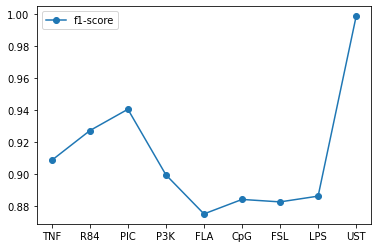

In [30]:
polarizedf1.plot(y='f1-score', style='o-')

<AxesSubplot:>

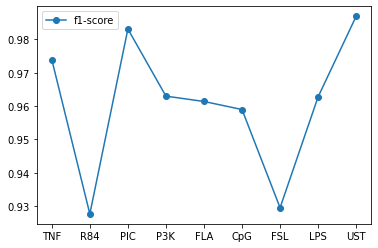

In [31]:
naivef1.plot(y='f1-score', style='o-')

<AxesSubplot:>

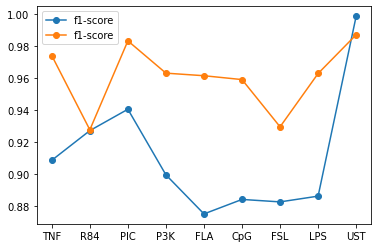

In [32]:
totalf1.plot(y='f1-score', style='o-') 

In [33]:
polarized_confusion = sklearn.metrics.confusion_matrix(df[0], df[1])
pccm = sklearn.metrics.ConfusionMatrixDisplay(polarized_confusion)

naive_confusion = sklearn.metrics.confusion_matrix(df2[0], df2[1])
nccm = sklearn.metrics.ConfusionMatrixDisplay(naive_confusion)

#polarized_fraction = sklearn.metrics.confusion_matrix(df3[0], df3[1])
#pcfm = sklearn.metrics.ConfusionMatrixDisplay(polarized_fraction)

#naive_fraction = sklearn.metrics.confusion_matrix(df4[0], df4[1])
#ncfm = sklearn.metrics.ConfusionMatrixDisplay(naive_fraction)

#test = sklearn.metrics.confusion_matrix(df5[0], df5[1])
#kek = sklearn.metrics.ConfusionMatrixDisplay(test)

In [34]:
print(df5)

             0         1
0     0.781249  0.999992
1     0.999717  0.999784
2     0.497632  0.999860
3     0.873699  0.824687
4     0.930744  0.990801
...        ...       ...
2875  0.998620  0.999943
2876  0.986070  0.971305
2877  0.954353  0.999951
2878  0.733176  0.983220
2879  0.890228  0.849673

[2880 rows x 2 columns]


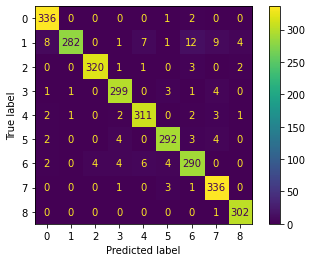

In [35]:
nccm.plot()

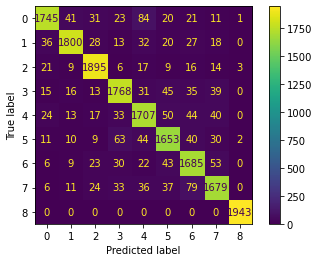

In [36]:
pccm.plot()

In [37]:
# pcfm.plot()

<h3>Polarization State Analysis</h3>

In [38]:
ligands = ["TNF", "R84", "PIC", "P3K", "FLA", "CpG", "FSL", "LPS", "UST"]
polarization = ["", "ib", "ig", "i0", "i3", "i4"]
replicas, size = 2, 1288

In [39]:
unpolarized_data = DatasetPolar(ligands, [""], replicas, size)
ib = DatasetPolar(ligands, ["ib"], replicas, size)
ig = DatasetPolar(ligands, ["ig"], replicas, size)
i0 = DatasetPolar(ligands, ["i0"], replicas, size)
i3 = DatasetPolar(ligands, ["i3"], replicas, size)
i4 = DatasetPolar(ligands, ["i4"], replicas, size)

In [40]:
print(len(unpolarized_data) + len(ib) + len(ig) + len(i0) + len(i3) + len(i4))
print(len(i4))

69552
11592


In [41]:
_, unpolarizedtest = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, ibtest = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, igtest = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, i0test = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, i3test = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, i4test = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])

uploader = torch.utils.data.DataLoader(unpolarizedtest, batch_size=32, shuffle=True)
ibloader = torch.utils.data.DataLoader(ibtest, batch_size=32, shuffle=True)
igloader = torch.utils.data.DataLoader(igtest, batch_size=32, shuffle=True)
i0loader = torch.utils.data.DataLoader(i0test, batch_size=32, shuffle=True)
i3loader = torch.utils.data.DataLoader(i3test, batch_size=32, shuffle=True)
i4loader = torch.utils.data.DataLoader(i4test, batch_size=32, shuffle=True)

<h3>Evaluation Loop</h3>

In [42]:
model.load(dir_load + 'lstm1.pth') # polarized

In [43]:
up_true, up_pred = np.empty([32,]), np.empty([32,])
ib_true, ib_pred = np.empty([32,]), np.empty([32,])

In [44]:
for x, y in uploader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    up_true = np.hstack([up_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = np.argmax(y_pred, axis=1)
    up_pred = np.hstack([up_pred, y_pred.T])
    #y_true = (32, ); y_pred = (32, ); y_prob = (32, 9)

In [45]:
for x, y in ibloader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    ib_true = np.hstack([up_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = np.argmax(y_pred, axis=1)
    ib_pred = np.hstack([up_pred, y_pred.T])
    #y_true = (32, ); y_pred = (32, ); y_prob = (32, 9)

In [46]:
up_true, up_pred = up_true[32:], up_pred[32:]
ib_true, ib_pred = ib_true[32:], ib_pred[32:]

In [47]:
up_df = np.vstack([up_true, up_pred]).T
up_df = pd.DataFrame(up_df)

ib_df = np.vstack([ib_true, ib_pred]).T
ib_df = pd.DataFrame(ib_df)

In [48]:
print(up_df)

        0    1
0     4.0  4.0
1     1.0  1.0
2     3.0  4.0
3     5.0  5.0
4     0.0  0.0
...   ...  ...
3195  5.0  5.0
3196  5.0  5.0
3197  5.0  5.0
3198  8.0  8.0
3199  2.0  2.0

[3200 rows x 2 columns]


In [49]:
print(f' Accuracy: {sum(up_df[0] == up_df[1])/3200}')

 Accuracy: 0.88875


In [50]:
print(ib_df)

        0    1
0     4.0  4.0
1     1.0  1.0
2     3.0  4.0
3     5.0  5.0
4     0.0  0.0
...   ...  ...
3227  0.0  0.0
3228  7.0  7.0
3229  7.0  7.0
3230  4.0  4.0
3231  0.0  0.0

[3232 rows x 2 columns]


In [51]:
print(f' Accuracy: {sum(ib_df[0] == ib_df[1])/3200}')

 Accuracy: 0.8978125
